In [1]:
# Step-0 → Load & quick structural check
import pandas as pd

df = pd.read_csv("Banana_Bank_Unstructured_Dataset_100k.csv")

df.shape

(100000, 18)

In [6]:
df.head() 

,transaction_id,customer_id,age,gender,city,account_type,account_balance,transaction_amount,transaction_type,channel,device,ip_address,merchant,transaction_time,transaction_status,kyc_completed,fraud_risk_score,remarks
0,TXN95745905,CUST70151,NaN,NaN,Mumbai,Current,472714.53,35913.25,IMPS,ATM,Android,10.1.2.161,Amazon,15/12/2023,Success,Yes,High,NaN
1,TXN79158445,CUST47274,NaN,M,Pune,Joint,414699.32,54104.82,NEFT,Web,Windows,NaN,Amazon,2023-12-14,Pending,NaN,Low,limit_exceeded
2,TXN72678765,CUST79310,NaN,NaN,Kolkata,Savings,NaN,72095.86,ATM,Mobile App,Windows,10.1.2.25,Flipkart,2022-04-09,Success,Y,Low,NaN
3,TXN20660017,CUST62707,NaN,Unknown,Mumbai,Salary,NaN,141475.66,UPI,Mobile App,NaN,10.1.2.153,Uber,2024-02-16 02:22:14,Success,NaN,High,NaN
4,TXN43669182,CUST40583,21.0,F,Kolkata,Current,NaN,106286.66,UPI,Branch,NaN,NaN,Zomato,24/10/2022,Success,NaN,0.06,suspicious_activity


In [7]:
df.info() # Shows which columns are object and need conversion later.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   transaction_id      100000 non-null  object 
 1   customer_id         100000 non-null  object 
 2   age                 33532 non-null   float64
 3   gender              83282 non-null   object 
 4   city                100000 non-null  object 
 5   account_type        100000 non-null  object 
 6   account_balance     50277 non-null   float64
 7   transaction_amount  100000 non-null  float64
 8   transaction_type    100000 non-null  object 
 9   channel             100000 non-null  object 
 10  device              80086 non-null   object 
 11  ip_address          33288 non-null   object 
 12  merchant            100000 non-null  object 
 13  transaction_time    100000 non-null  object 
 14  transaction_status  100000 non-null  object 
 15  kyc_completed       79783 non-null 

In [8]:
# ✅ Step-1 → Create a copy for cleaning (important)

df_clean = df.copy()  # Never destroy raw data.

In [10]:
# ✅ Step-2 → Standardise text columns

# ✔ City cleaning
df_clean["city"] = df_clean["city"].astype(str).str.strip()  # Removes extra spaces like "Delhi " → "Delhi"

# ✔ Gender standardisation
df_clean["gender"] = df_clean["gender"].replace({
    "M": "Male",
    "F": "Female"
}) # Converts M/F

df_clean["gender"] = df_clean["gender"].where(
    df_clean["gender"].isin(["Male", "Female"]),
    "Unknown"
) # Everything else becomes "Unknown"

# ✔ KYC flag standardisation
df_clean["kyc_completed"] = df_clean["kyc_completed"].replace({
    "Y": 1, "Yes": 1,
    "N": 0, "No": 0
}) # Converts messy yes/no into numeric flag / # Very important for later risk analysis

C:\Users\sc978\AppData\Local\Temp\ipykernel_12564\1303884673.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean["kyc_completed"] = df_clean["kyc_completed"].replace({


In [11]:
# ✅ Step-3 → Fix numeric columns
# ✔ Age
df_clean["age"] = pd.to_numeric(df_clean["age"], errors="coerce") # "NA", "", text, → into NaN

# ✔ Account balance
df_clean["account_balance"] = pd.to_numeric(
    df_clean["account_balance"], errors="coerce"
)   # Removes empty strings and Converts to proper float

# ✔ Fraud risk score (very important)
# This column has: numeric, "High", "Low". so, Convert to a unified numeric score.
df_clean["fraud_risk_score"] = df_clean["fraud_risk_score"].replace({
    "Low": 0.2,
    "High": 0.8
}) # numeric risk between 0–1

df_clean["fraud_risk_score"] = pd.to_numeric(
    df_clean["fraud_risk_score"], errors="coerce"
) # ready for analysis

In [12]:
# ✅ Step-4 → Fix transaction time (mixed formats)
# our dataset contains: yyyy-mm-dd, dd/mm/yyyy, yyyy-mm-dd hh:mm:ss
df_clean["transaction_time"] = pd.to_datetime(
    df_clean["transaction_time"],
    errors="coerce",
    dayfirst=True
) # Pandas automatically handles mixed formats, dayfirst=True fixes Indian style dates

In [14]:
# ✅ Step-5 → Validate business rules
# ✔ Invalid ages
invalid_age = df_clean[
    (df_clean["age"] < 18) | (df_clean["age"] > 100)
] # we keep this for reporting / data quality section

# ✔ Negative balances
negative_balance = df_clean[
    df_clean["account_balance"] < 0
] # Important for credit & overdraft risk questions

# ✔ Missing IPs
missing_ip = df_clean["ip_address"].isna().sum()
missing_ip # Platform security & fraud relevance

np.int64(66712)

In [15]:
# ✅ Step-6 → Create helper features (for analysis later)
# ✔ Transaction date
df_clean["txn_date"] = df_clean["transaction_time"].dt.date

# ✔ Transaction hour
df_clean["txn_hour"] = df_clean["transaction_time"].dt.hour

#Because -> Later helps in: abnormal behaviour, night fraud patterns

In [16]:
# ✅ Step-7 → Save your clean dataset
df_clean.to_csv("Banana_Bank_Cleaned_Dataset.csv", index=False)

In [17]:
# 1️⃣ Which transactions have high fraud risk but still succeeded?

Total successful transactions: 33330
High-risk but approved transactions: 13429
Total risky exposure amount: 993363252.8199999
Risk leakage percentage: 40.29 %
  transaction_type  risky_txn_count  risky_amount
5              UPI             2234  1.681006e+08
2             Cash             2260  1.675381e+08
1             Card             2238  1.655494e+08
4             NEFT             2258  1.643800e+08
0              ATM             2217  1.641257e+08
3             IMPS             2222  1.636694e+08


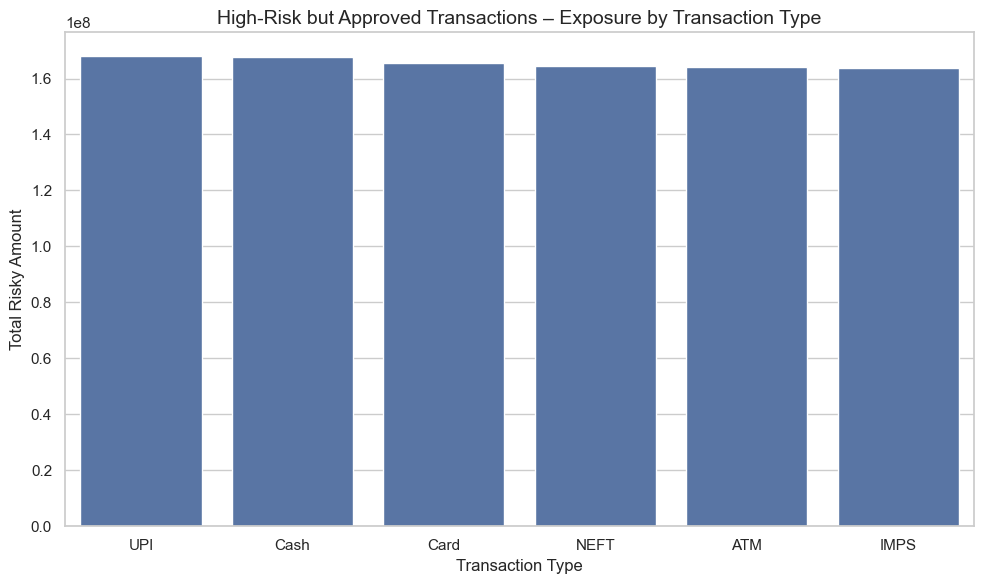

,transaction_id,customer_id,transaction_amount,fraud_risk_score,transaction_type,merchant,city,channel,device,transaction_time
68560,TXN76686583,CUST52813,148469.31,1.0,ATM,LocalStore,Kolkata,Web,Android,NaN
78510,TXN37061393,CUST32420,146065.66,1.0,Cash,Flipkart,Bengaluru,Branch,Windows,NaN
8986,TXN36060862,CUST96796,142861.72,1.0,NEFT,IRCTC,Mumbai,Branch,Windows,2023-06-14
30975,TXN96104889,CUST72710,141345.31,1.0,UPI,Ola,Delhi,Mobile App,Linux,NaN
39539,TXN75431737,CUST46014,140019.03,1.0,UPI,Swiggy,Mumbai,Web,Windows,NaN
86864,TXN51862418,CUST80205,139484.45,1.0,Cash,Swiggy,Noida,Mobile App,Windows,NaN
21696,TXN63931650,CUST83453,137773.74,1.0,Cash,Uber,Noida,ATM,Android,NaN
81721,TXN82011253,CUST70486,135824.09,1.0,Cash,Uber,Chennai,Mobile App,Android,NaN
36810,TXN81764587,CUST52973,129690.94,1.0,NEFT,Swiggy,Kolkata,Mobile App,Linux,2023-10-10
7676,TXN53690928,CUST16136,127315.33,1.0,NEFT,IRCTC,Kolkata,ATM,NaN,2022-04-03


In [18]:
# -----------------------------------------------------------
# Question 1 – High risk transactions that were still approved
# Professional single-pipeline analysis with visualization
# -----------------------------------------------------------

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 1. Load cleaned dataset
# (We always use the cleaned file for business analysis)
# -------------------------------
df = pd.read_csv("Banana_Bank_Cleaned_Dataset.csv")

# -------------------------------
# 2. Define business rule
# High fraud risk  = fraud_risk_score >= 0.8
# Approved         = transaction_status == "Success"
# -------------------------------

high_risk_success = df.loc[
    (df["fraud_risk_score"] >= 0.8) &
    (df["transaction_status"] == "Success")
].copy()

# -------------------------------
# 3. Core business KPIs
# -------------------------------

# Total number of approved transactions
total_success_txns = df.loc[
    df["transaction_status"] == "Success"
].shape[0]

# Number of risky but approved transactions
risky_approved_count = high_risk_success.shape[0]

# Total money exposed in risky approved transactions
risky_exposure_amount = high_risk_success["transaction_amount"].sum()

# Percentage leakage
risk_leakage_ratio = (risky_approved_count / total_success_txns) * 100

print("Total successful transactions:", total_success_txns)
print("High-risk but approved transactions:", risky_approved_count)
print("Total risky exposure amount:", risky_exposure_amount)
print("Risk leakage percentage:", round(risk_leakage_ratio, 2), "%")


# -------------------------------
# 4. Business breakdown
# Channel / transaction type wise
# (Where is the main leakage coming from?)
# -------------------------------

channel_summary = (
    high_risk_success
        .groupby("transaction_type")
        .agg(
            risky_txn_count=("transaction_id", "count"),
            risky_amount=("transaction_amount", "sum")
        )
        .reset_index()
        .sort_values("risky_amount", ascending=False)
)

print(channel_summary)


# -------------------------------
# 5. Visualization
# High-risk approved exposure by transaction type
# -------------------------------

sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6))

sns.barplot(
    data=channel_summary,
    x="transaction_type",
    y="risky_amount"
)

plt.title(
    "High-Risk but Approved Transactions – Exposure by Transaction Type",
    fontsize=14
)

plt.xlabel("Transaction Type")
plt.ylabel("Total Risky Amount")

plt.tight_layout()
plt.show()


# -------------------------------
# 6. Create investigation list
# (Used by fraud / operations team)
# -------------------------------

review_list = (
    high_risk_success[
        [
            "transaction_id",
            "customer_id",
            "transaction_amount",
            "fraud_risk_score",
            "transaction_type",
            "merchant",
            "city",
            "channel",
            "device",
            "transaction_time"
        ]
    ]
    .sort_values(
        by=["fraud_risk_score", "transaction_amount"],
        ascending=False
    )
)

# Preview top 20 most critical cases
review_list.head(20)

In [19]:
# ✅ Question-2 Which customers are generating repeated failed transactions?

Customers with at least one failed transaction: 27968
Customers with repeated failed transactions: 4815
Percentage of customers at churn risk: 17.22 %
      customer_id  failed_txn_count  total_failed_amount
1233    CUST13939                 5            523834.81
20692   CUST76588                 5            413208.94
24450   CUST88823                 5            335728.43
13722   CUST53996                 5            405151.27
24462   CUST88862                 4            209235.61
27401   CUST98151                 4            401164.95
18583   CUST69758                 4            373563.94
15938   CUST61146                 4            224816.45
22458   CUST82485                 4            322431.25
23242   CUST85006                 4            106807.18


C:\Users\sc978\AppData\Local\Temp\ipykernel_12564\285407830.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


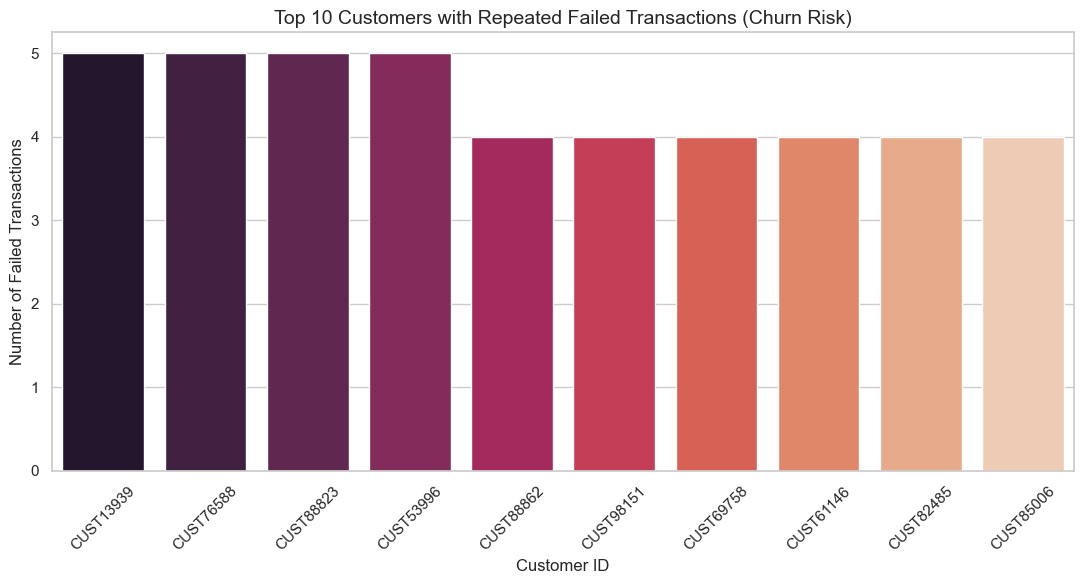

,customer_id,failed_txn_count,total_failed_amount,churn_risk_level
1233,CUST13939,5,523834.81,Medium
20692,CUST76588,5,413208.94,Medium
24450,CUST88823,5,335728.43,Medium
13722,CUST53996,5,405151.27,Medium
24462,CUST88862,4,209235.61,Low
27401,CUST98151,4,401164.95,Low
18583,CUST69758,4,373563.94,Low
15938,CUST61146,4,224816.45,Low
22458,CUST82485,4,322431.25,Low
23242,CUST85006,4,106807.18,Low


In [20]:
# ------------------------------------------------------------
# Answer 2 – Customers with repeated failed transactions
# Business impact: customer frustration and churn risk
# ------------------------------------------------------------
# 1. Keep only failed transactions
#    We focus only on failure behaviour for churn analysis
# ------------------------------------------------------------
failed_txns = df.loc[
    df["transaction_status"] == "Failed"
].copy()


# ------------------------------------------------------------
# 2. Find customers with repeated failures
#    (count how many failed transactions each customer has)
# ------------------------------------------------------------
customer_failures = (
    failed_txns
        .groupby("customer_id")
        .agg(
            failed_txn_count=("transaction_id", "count"),
            total_failed_amount=("transaction_amount", "sum")
        )
        .reset_index()
)


# ------------------------------------------------------------
# 3. Keep only customers who failed more than once
#    (Repeated failures = real churn risk signal)
# ------------------------------------------------------------
repeated_failed_customers = customer_failures.loc[
    customer_failures["failed_txn_count"] > 1
].sort_values(
    by="failed_txn_count",
    ascending=False
)


# ------------------------------------------------------------
# 4. Business KPIs for management
# ------------------------------------------------------------

total_customers_with_failure = customer_failures.shape[0]
repeated_failure_customers = repeated_failed_customers.shape[0]

print("Customers with at least one failed transaction:",
      total_customers_with_failure)

print("Customers with repeated failed transactions:",
      repeated_failure_customers)

print("Percentage of customers at churn risk:",
      round((repeated_failure_customers /
             total_customers_with_failure) * 100, 2),
      "%")


# ------------------------------------------------------------
# 5. Top churn-risk customers (operational priority list)
# ------------------------------------------------------------

top_churn_risk_customers = repeated_failed_customers.head(10)
print(top_churn_risk_customers)


# ------------------------------------------------------------
# 6. Visualization – Top 10 customers with repeated failures
#    (colored chart as requested)
# ------------------------------------------------------------

sns.set_theme(style="whitegrid")

plt.figure(figsize=(11, 6))

# Using a professional color palette
palette = sns.color_palette("rocket", n_colors=10)

sns.barplot(
    data=top_churn_risk_customers,
    x="customer_id",
    y="failed_txn_count",
    palette=palette
)

plt.title(
    "Top 10 Customers with Repeated Failed Transactions (Churn Risk)",
    fontsize=14
)

plt.xlabel("Customer ID")
plt.ylabel("Number of Failed Transactions")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# ------------------------------------------------------------
# 7. Add experience severity label
#    (helps business teams segment customers)
# ------------------------------------------------------------

def churn_risk_label(count):
    if count >= 10:
        return "High"
    elif count >= 5:
        return "Medium"
    else:
        return "Low"

repeated_failed_customers["churn_risk_level"] = (
    repeated_failed_customers["failed_txn_count"]
        .apply(churn_risk_label)
)


# ------------------------------------------------------------
# 8. Final churn review table
#    (ready for CRM / customer support team)
# ------------------------------------------------------------

churn_review_table = repeated_failed_customers[
    [
        "customer_id",
        "failed_txn_count",
        "total_failed_amount",
        "churn_risk_level"
    ]
]

churn_review_table.head(20)

In [21]:
# 3️⃣ Which cities contribute the highest transaction value but also the highest failure rate?

        city  total_txns  total_txn_value  failed_txns  failure_rate
6     Mumbai       11363     8.568494e+08         3866     34.022705
8       Pune       11271     8.396143e+08         3776     33.501908
5    Kolkata       10997     8.253306e+08         3592     32.663454
0  Bengaluru       11168     8.234076e+08         3685     32.996060
7      Noida       11071     8.226212e+08         3742     33.800018
2      Delhi       11081     8.197605e+08         3686     33.264146
1    Chennai       11113     8.196310e+08         3666     32.988392
3    Gurgaon       10962     8.155040e+08         3686     33.625251
4  Hyderabad       10974     8.090337e+08         3699     33.706944
        city  total_txns  total_txn_value  failed_txns  failure_rate
6     Mumbai       11363     8.568494e+08         3866     34.022705
8       Pune       11271     8.396143e+08         3776     33.501908
5    Kolkata       10997     8.253306e+08         3592     32.663454
0  Bengaluru       11168     8.234

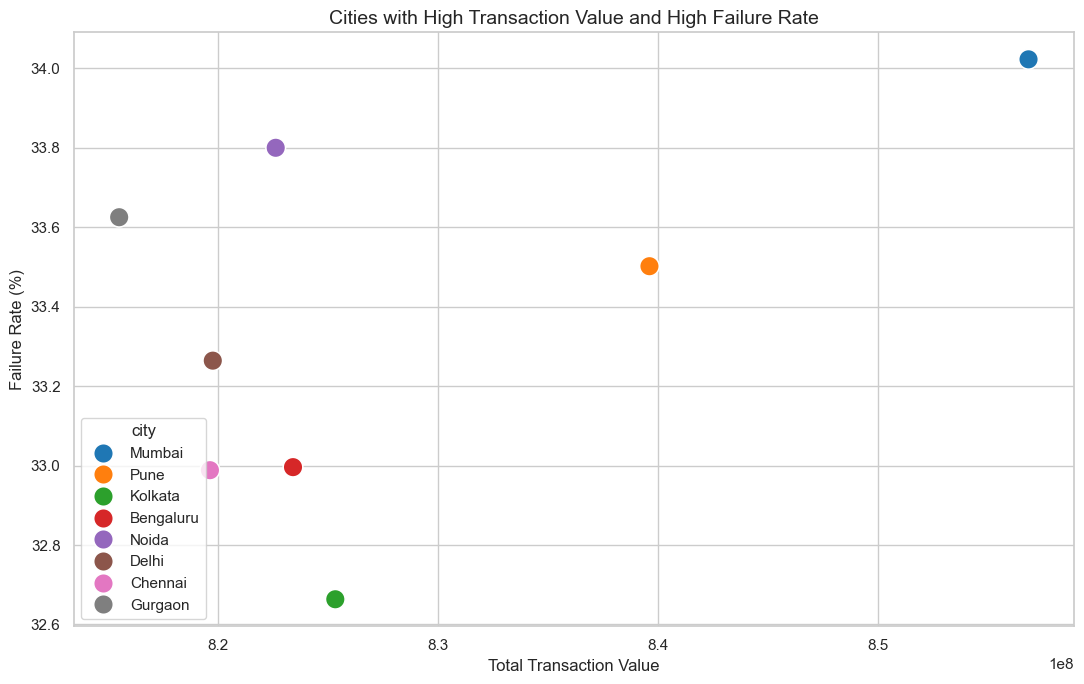

High operational risk cities:


,city,total_txns,total_txn_value,failed_txns,failure_rate
6,Mumbai,11363,8.568494e+08,3866,34.022705
8,Pune,11271,8.396143e+08,3776,33.501908


In [22]:
# ------------------------------------------------------------------
# Answern 3 – Cities with high transaction value
#               AND high failure rate
# Business impact: operational & infrastructure risk by region
# ------------------------------------------------------------------
# 1. Create a failure flag
#    (This makes failure-rate calculation very easy and clean)
# ------------------------------------------------------------------
df["is_failed"] = (df["transaction_status"] == "Failed").astype(int)


# ------------------------------------------------------------------
# 2. City level aggregation
#    We calculate:
#      - total transactions
#      - total transaction value
#      - number of failed transactions
# ------------------------------------------------------------------
city_summary = (
    df
        .groupby("city")
        .agg(
            total_txns=("transaction_id", "count"),
            total_txn_value=("transaction_amount", "sum"),
            failed_txns=("is_failed", "sum")
        )
        .reset_index()
)


# ------------------------------------------------------------------
# 3. Failure rate calculation
# ------------------------------------------------------------------
city_summary["failure_rate"] = (
    city_summary["failed_txns"] / city_summary["total_txns"]
) * 100


# ------------------------------------------------------------------
# 4. Sort cities by total transaction value (business priority)
# ------------------------------------------------------------------
city_summary = city_summary.sort_values(
    by="total_txn_value",
    ascending=False
)

print(city_summary)


# ------------------------------------------------------------------
# 5. Management view
#    Top cities by transaction value
#    (these are the cities where failures hurt the most)
# ------------------------------------------------------------------
top_cities = city_summary.head(8)
print(top_cities)


# ------------------------------------------------------------------
# 6. Professional visualization
#    Scatter plot:
#    X = total transaction value
#    Y = failure rate
#    Color = city
# ------------------------------------------------------------------

sns.set_theme(style="whitegrid")

plt.figure(figsize=(11, 7))

sns.scatterplot(
    data=top_cities,
    x="total_txn_value",
    y="failure_rate",
    hue="city",
    s=200,
    palette="tab10"
)

plt.title(
    "Cities with High Transaction Value and High Failure Rate",
    fontsize=14
)

plt.xlabel("Total Transaction Value")
plt.ylabel("Failure Rate (%)")

plt.tight_layout()
plt.show()


# ------------------------------------------------------------------
# 7. High-risk operational cities
#    (Cities with both:
#      - above average transaction value
#      - above average failure rate)
# ------------------------------------------------------------------

value_threshold = city_summary["total_txn_value"].mean()
failure_threshold = city_summary["failure_rate"].mean()

high_risk_cities = city_summary[
    (city_summary["total_txn_value"] >= value_threshold) &
    (city_summary["failure_rate"] >= failure_threshold)
]

print("High operational risk cities:")
high_risk_cities

In [23]:
# ✅ Question 4 -Is digital channel (Mobile App / Web) really performing better than Branch & ATM?

  channel_group  total_txns   total_value  success_txns  failed_txns  \
0       Digital       49965  3.704732e+09         16626        16673   
1      Physical       50035  3.727020e+09         16704        16725   

   success_rate  failure_rate  
0     33.275293     33.369359  
1     33.384631     33.426601  


C:\Users\sc978\AppData\Local\Temp\ipykernel_12564\2521925305.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


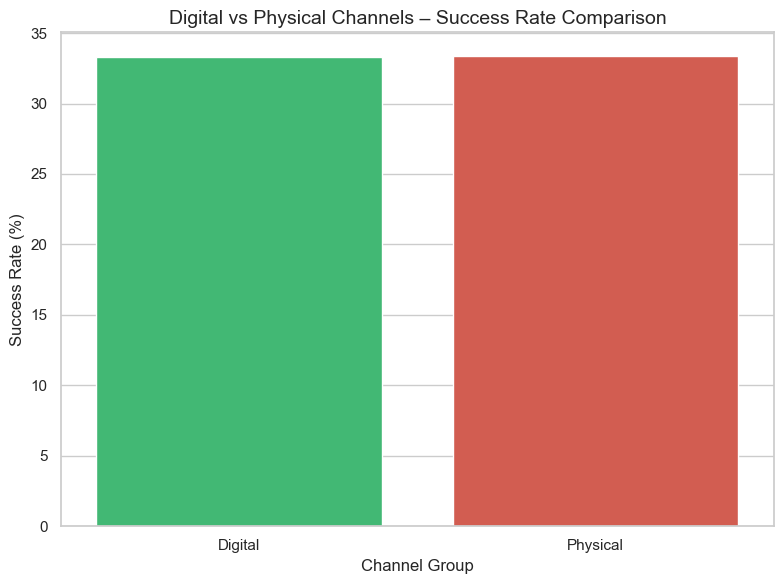

C:\Users\sc978\AppData\Local\Temp\ipykernel_12564\2521925305.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


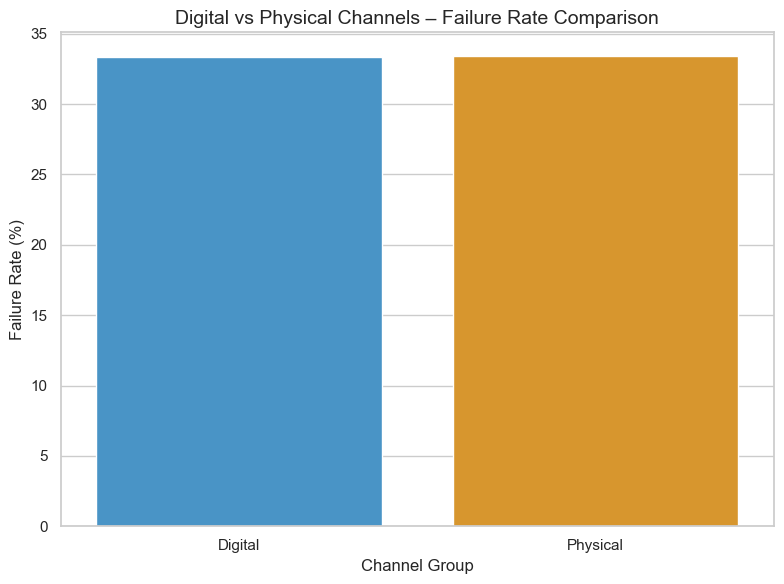

In [24]:
# --------------------------------------------------------------------
# Answer 4 – Digital channels vs Physical channels performance
# Digital  : Mobile App, Web
# Physical : Branch, ATM
# --------------------------------------------------------------------
# 1. Create channel group (Digital vs Physical)
#    This converts raw channel into business categories
# --------------------------------------------------------------------
df["channel_group"] = df["channel"].map(
    {
        "Mobile App": "Digital",
        "Web": "Digital",
        "Branch": "Physical",
        "ATM": "Physical"
    }
)


# --------------------------------------------------------------------
# 2. Create success & failure flags
#    This makes rate calculations easy and clean
# --------------------------------------------------------------------
df["is_success"] = (df["transaction_status"] == "Success").astype(int)
df["is_failed"]  = (df["transaction_status"] == "Failed").astype(int)


# --------------------------------------------------------------------
# 3. Channel group level performance summary
#    We calculate:
#      - total transactions
#      - total value
#      - successes
#      - failures
# --------------------------------------------------------------------
channel_perf = (
    df
        .groupby("channel_group")
        .agg(
            total_txns=("transaction_id", "count"),
            total_value=("transaction_amount", "sum"),
            success_txns=("is_success", "sum"),
            failed_txns=("is_failed", "sum")
        )
        .reset_index()
)


# --------------------------------------------------------------------
# 4. KPI calculations
# --------------------------------------------------------------------
channel_perf["success_rate"] = (
    channel_perf["success_txns"] / channel_perf["total_txns"]
) * 100

channel_perf["failure_rate"] = (
    channel_perf["failed_txns"] / channel_perf["total_txns"]
) * 100

print(channel_perf)


# --------------------------------------------------------------------
# 5. Visualization – Success rate comparison
#    (colored professional chart)
# --------------------------------------------------------------------

sns.set_theme(style="whitegrid")

plt.figure(figsize=(8, 6))

sns.barplot(
    data=channel_perf,
    x="channel_group",
    y="success_rate",
    palette=["#2ecc71", "#e74c3c"]
)

plt.title(
    "Digital vs Physical Channels – Success Rate Comparison",
    fontsize=14
)

plt.xlabel("Channel Group")
plt.ylabel("Success Rate (%)")

plt.tight_layout()
plt.show()


# --------------------------------------------------------------------
# 6. Visualization – Failure rate comparison
#    (colored professional chart)
# --------------------------------------------------------------------

plt.figure(figsize=(8, 6))

sns.barplot(
    data=channel_perf,
    x="channel_group",
    y="failure_rate",
    palette=["#3498db", "#f39c12"]
)

plt.title(
    "Digital vs Physical Channels – Failure Rate Comparison",
    fontsize=14
)

plt.xlabel("Channel Group")
plt.ylabel("Failure Rate (%)")

plt.tight_layout()
plt.show()

In [25]:
# ✅ Question 5 -Which merchants are most associated with suspicious or high-risk transactions?

     merchant  total_txns  suspicious_txns  suspicious_amount  suspicious_rate
5      Swiggy       12610             5594       4.088216e+08        44.361618
7      Zomato       12556             5560       4.155854e+08        44.281618
3  LocalStore       12686             5553       4.116527e+08        43.772663
0      Amazon       12413             5372       3.972063e+08        43.277209
1    Flipkart       12151             5258       3.872761e+08        43.272159
2       IRCTC       12563             5408       4.034822e+08        43.047043
6        Uber       12536             5391       4.014802e+08        43.004148
4         Ola       12485             5356       4.017515e+08        42.899479


C:\Users\sc978\AppData\Local\Temp\ipykernel_12564\3955948333.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


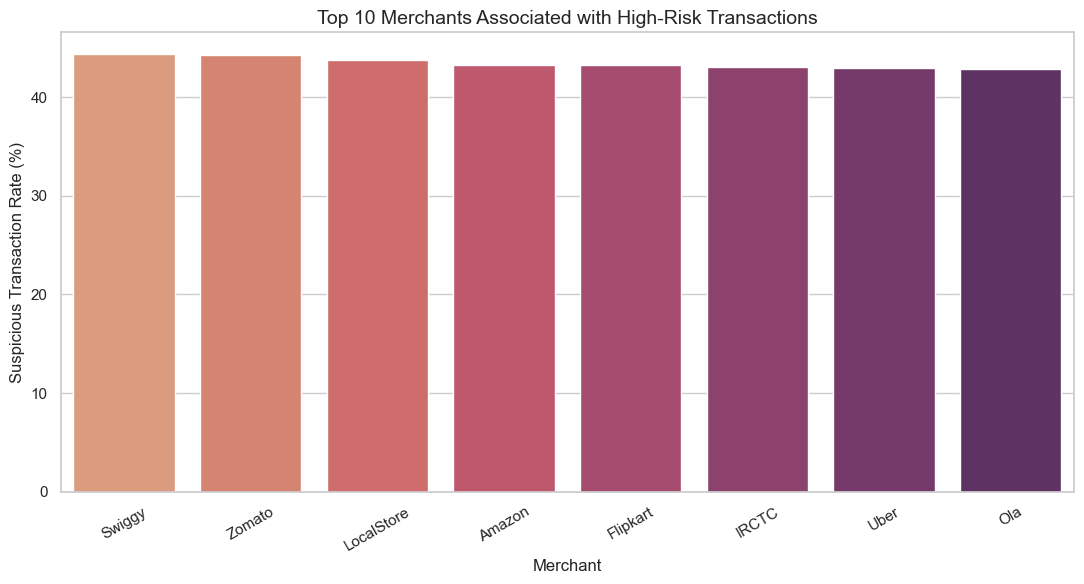

,merchant,total_txns,suspicious_txns,suspicious_amount,suspicious_rate
5,Swiggy,12610,5594,4.088216e+08,44.361618
7,Zomato,12556,5560,4.155854e+08,44.281618
3,LocalStore,12686,5553,4.116527e+08,43.772663
0,Amazon,12413,5372,3.972063e+08,43.277209
1,Flipkart,12151,5258,3.872761e+08,43.272159
2,IRCTC,12563,5408,4.034822e+08,43.047043
6,Uber,12536,5391,4.014802e+08,43.004148
4,Ola,12485,5356,4.017515e+08,42.899479


In [26]:
# --------------------------------------------------------------------
# Answer 5 – Merchants associated with suspicious / high-risk activity
# Suspicious definition:
#    fraud_risk_score >= 0.7   (bank risk threshold)
# --------------------------------------------------------------------
# 1. Define suspicious / high-risk transactions
#    We treat fraud_risk_score >= 0.7 as suspicious
# --------------------------------------------------------------------
suspicious_txns = df.loc[
    df["fraud_risk_score"] >= 0.7
].copy()


# --------------------------------------------------------------------
# 2. Merchant level risk aggregation
#    We calculate:
#      - total transactions per merchant
#      - suspicious transactions per merchant
#      - suspicious transaction amount
# --------------------------------------------------------------------

merchant_summary = (
    df
        .groupby("merchant")
        .agg(
            total_txns=("transaction_id", "count"),
            suspicious_txns=("fraud_risk_score", lambda x: (x >= 0.7).sum()),
            suspicious_amount=("transaction_amount",
                                lambda x: x[df.loc[x.index, "fraud_risk_score"] >= 0.7].sum())
        )
        .reset_index()
)


# --------------------------------------------------------------------
# 3. Suspicious rate per merchant
# --------------------------------------------------------------------
merchant_summary["suspicious_rate"] = (
    merchant_summary["suspicious_txns"] / merchant_summary["total_txns"]
) * 100


# --------------------------------------------------------------------
# 4. Focus on merchants with real volume
#    (avoid noise from very small merchants)
# --------------------------------------------------------------------
merchant_summary = merchant_summary.loc[
    merchant_summary["total_txns"] >= 200
]


# --------------------------------------------------------------------
# 5. Rank merchants by suspicious rate
# --------------------------------------------------------------------
top_risky_merchants = merchant_summary.sort_values(
    by="suspicious_rate",
    ascending=False
).head(10)

print(top_risky_merchants)


# --------------------------------------------------------------------
# 6. Visualization – Top 10 risky merchants by suspicious rate
#    (colored professional bar chart)
# --------------------------------------------------------------------

sns.set_theme(style="whitegrid")

plt.figure(figsize=(11, 6))

palette = sns.color_palette("flare", n_colors=len(top_risky_merchants))

sns.barplot(
    data=top_risky_merchants,
    x="merchant",
    y="suspicious_rate",
    palette=palette
)

plt.title(
    "Top 10 Merchants Associated with High-Risk Transactions",
    fontsize=14
)

plt.xlabel("Merchant")
plt.ylabel("Suspicious Transaction Rate (%)")

plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


# --------------------------------------------------------------------
# 7. Investigation ready merchant table
#    (for risk & compliance teams)
# --------------------------------------------------------------------

merchant_risk_review = top_risky_merchants[
    [
        "merchant",
        "total_txns",
        "suspicious_txns",
        "suspicious_amount",
        "suspicious_rate"
    ]
]

merchant_risk_review

In [27]:
# ✅ Question 6 - Are KYC-incomplete customers more risky than KYC-completed customers?

       kyc_status  total_txns  high_risk_txns  failed_txns  avg_fraud_score  \
0   KYC Completed       39878           17291        13352         0.499504   
1  KYC Incomplete       39905           17404        13384         0.499913   

   high_risk_rate  failure_rate  
0       43.359747     33.482120  
1       43.613582     33.539657  


C:\Users\sc978\AppData\Local\Temp\ipykernel_12564\3754845538.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


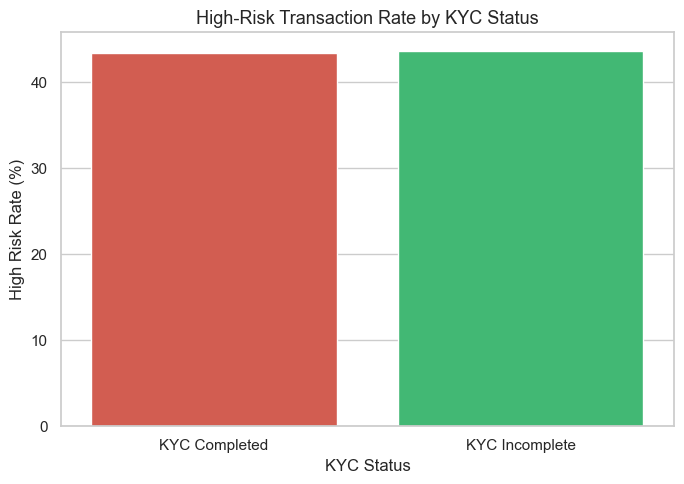

C:\Users\sc978\AppData\Local\Temp\ipykernel_12564\3754845538.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


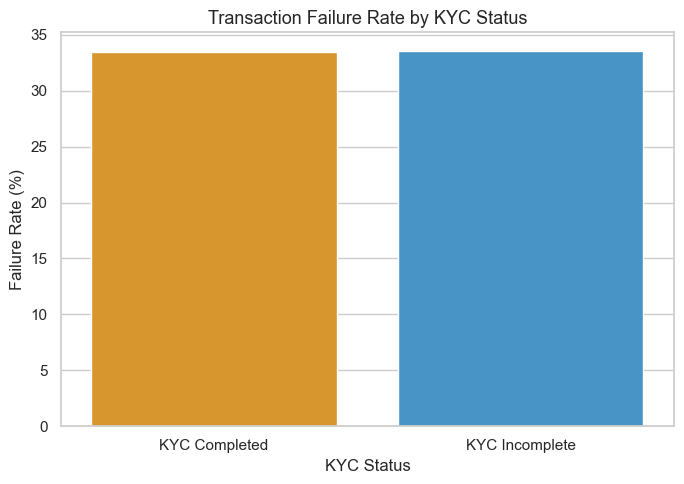

In [28]:
# --------------------------------------------------------------------
# Answer 6 – Risk comparison between
#               KYC completed vs KYC incomplete customers
# --------------------------------------------------------------------

# 1. Prepare KYC flag for business reporting
#    (1 = Completed, 0 = Incomplete)
# --------------------------------------------------------------------
df["kyc_status"] = df["kyc_completed"].map(
    {
        1: "KYC Completed",
        0: "KYC Incomplete"
    }
)

# remove records where KYC information is missing
df = df[df["kyc_status"].notna()].copy()


# --------------------------------------------------------------------
# 2. Create risk flags
#    We treat fraud_risk_score >= 0.7 as high risk
# --------------------------------------------------------------------
df["is_high_risk"] = (df["fraud_risk_score"] >= 0.7).astype(int)
df["is_failed"]    = (df["transaction_status"] == "Failed").astype(int)


# --------------------------------------------------------------------
# 3. KYC level risk summary
#    We calculate:
#      - total transactions
#      - high risk transactions
#      - failed transactions
#      - average fraud score
# --------------------------------------------------------------------
kyc_risk_summary = (
    df
        .groupby("kyc_status")
        .agg(
            total_txns=("transaction_id", "count"),
            high_risk_txns=("is_high_risk", "sum"),
            failed_txns=("is_failed", "sum"),
            avg_fraud_score=("fraud_risk_score", "mean")
        )
        .reset_index()
)


# --------------------------------------------------------------------
# 4. KPI calculations
# --------------------------------------------------------------------
kyc_risk_summary["high_risk_rate"] = (
    kyc_risk_summary["high_risk_txns"] / kyc_risk_summary["total_txns"]
) * 100

kyc_risk_summary["failure_rate"] = (
    kyc_risk_summary["failed_txns"] / kyc_risk_summary["total_txns"]
) * 100

print(kyc_risk_summary)


# --------------------------------------------------------------------
# 5. Visualization – High risk rate comparison
#    (colored professional chart)
# --------------------------------------------------------------------

sns.set_theme(style="whitegrid")

plt.figure(figsize=(7, 5))

sns.barplot(
    data=kyc_risk_summary,
    x="kyc_status",
    y="high_risk_rate",
    palette=["#e74c3c", "#2ecc71"]
)

plt.title(
    "High-Risk Transaction Rate by KYC Status",
    fontsize=13
)

plt.xlabel("KYC Status")
plt.ylabel("High Risk Rate (%)")

plt.tight_layout()
plt.show()


# --------------------------------------------------------------------
# 6. Visualization – Failure rate comparison
# --------------------------------------------------------------------

plt.figure(figsize=(7, 5))

sns.barplot(
    data=kyc_risk_summary,
    x="kyc_status",
    y="failure_rate",
    palette=["#f39c12", "#3498db"]
)

plt.title(
    "Transaction Failure Rate by KYC Status",
    fontsize=13
)

plt.xlabel("KYC Status")
plt.ylabel("Failure Rate (%)")

plt.tight_layout()
plt.show()

In [29]:
# 7️⃣ Which devices and platforms show higher fraud risk and failure rate?

    device  total_txns  high_risk_txns  failed_txns  avg_fraud_score  \
0  Android       16032            7043         5414         0.504046   
2  Unknown       15936            6988         5339         0.502135   
3  Windows       15907            6934         5366         0.498897   
1    Linux       15855            6828         5277         0.496554   
4      iOS       16053            6902         5340         0.496890   

   high_risk_rate  failure_rate  
0       43.930888     33.769960  
2       43.850402     33.502761  
3       43.590872     33.733576  
1       43.065279     33.282876  
4       42.995079     33.264810  


C:\Users\sc978\AppData\Local\Temp\ipykernel_12564\2886502566.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


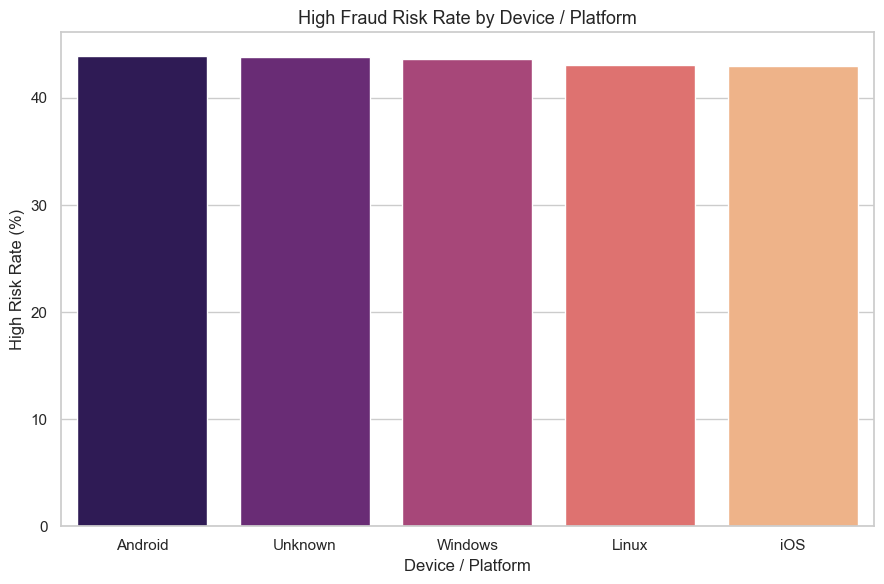

C:\Users\sc978\AppData\Local\Temp\ipykernel_12564\2886502566.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


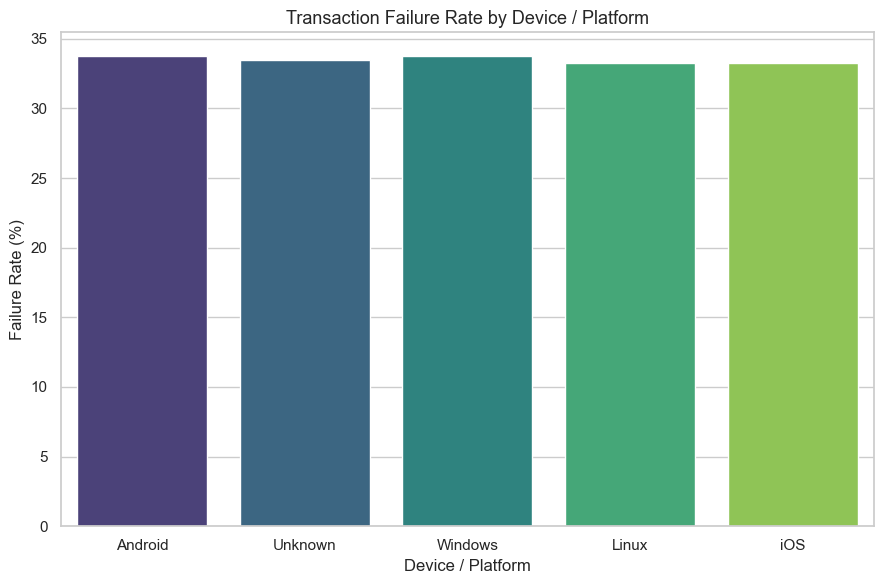

In [30]:
# --------------------------------------------------------------------
# Answer 7 – Device / platform level fraud risk & failure analysis
# --------------------------------------------------------------------

# 1. Clean and standardise device information
#    (avoid noise such as NA or empty devices)
# --------------------------------------------------------------------
df["device"] = df["device"].fillna("Unknown")

df = df[~df["device"].isin(["", "NA"])].copy()


# --------------------------------------------------------------------
# 2. Create risk and failure flags
#    High fraud risk definition remains consistent with earlier analysis
# --------------------------------------------------------------------
df["is_high_risk"] = (df["fraud_risk_score"] >= 0.7).astype(int)
df["is_failed"] = (df["transaction_status"] == "Failed").astype(int)


# --------------------------------------------------------------------
# 3. Device level performance & risk summary
#    We calculate:
#      - total transactions
#      - high-risk transactions
#      - failed transactions
#      - average fraud score
# --------------------------------------------------------------------
device_summary = (
    df
        .groupby("device")
        .agg(
            total_txns=("transaction_id", "count"),
            high_risk_txns=("is_high_risk", "sum"),
            failed_txns=("is_failed", "sum"),
            avg_fraud_score=("fraud_risk_score", "mean")
        )
        .reset_index()
)


# --------------------------------------------------------------------
# 4. KPI calculations
# --------------------------------------------------------------------
device_summary["high_risk_rate"] = (
    device_summary["high_risk_txns"] / device_summary["total_txns"]
) * 100

device_summary["failure_rate"] = (
    device_summary["failed_txns"] / device_summary["total_txns"]
) * 100


# Focus only on devices with meaningful volume
device_summary = device_summary[
    device_summary["total_txns"] >= 500
].sort_values("high_risk_rate", ascending=False)

print(device_summary)


# --------------------------------------------------------------------
# 5. Visualization – High fraud risk rate by device
#    (colored professional bar chart)
# --------------------------------------------------------------------

sns.set_theme(style="whitegrid")

plt.figure(figsize=(9, 6))

palette1 = sns.color_palette("magma", n_colors=len(device_summary))

sns.barplot(
    data=device_summary,
    x="device",
    y="high_risk_rate",
    palette=palette1
)

plt.title(
    "High Fraud Risk Rate by Device / Platform",
    fontsize=13
)

plt.xlabel("Device / Platform")
plt.ylabel("High Risk Rate (%)")

plt.tight_layout()
plt.show()


# --------------------------------------------------------------------
# 6. Visualization – Failure rate by device
# --------------------------------------------------------------------

plt.figure(figsize=(9, 6))

palette2 = sns.color_palette("viridis", n_colors=len(device_summary))

sns.barplot(
    data=device_summary,
    x="device",
    y="failure_rate",
    palette=palette2
)

plt.title(
    "Transaction Failure Rate by Device / Platform",
    fontsize=13
)

plt.xlabel("Device / Platform")
plt.ylabel("Failure Rate (%)")

plt.tight_layout()
plt.show()

In [31]:
# 8️⃣ Which customer segments have negative balances and high transaction activity?

High-activity threshold (transactions): 2.0
Number of risky & highly active customers: 82
   age_group account_type  customer_count  avg_txn_count  avg_negative_balance
2      18-25       Salary               5       2.400000          -3579.286000
15     46-60      Savings               5       2.200000          -1462.334000
13     46-60        Joint               5       2.600000          -2214.908000
4      26-35      Current               5       2.000000          -2440.450000
0      18-25      Current               4       2.250000          -2634.632500
17       60+        Joint               4       2.000000          -2841.905000
16       60+      Current               3       2.000000          -3485.046667
11     36-45      Savings               3       2.333333          -2302.276667
12     46-60      Current               3       2.333333          -2765.486667
8      36-45      Current               3       2.000000          -1671.533333
10     36-45       Salary               3

C:\Users\sc978\AppData\Local\Temp\ipykernel_12564\2443754171.py:66: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["age_group", "account_type"])
C:\Users\sc978\AppData\Local\Temp\ipykernel_12564\2443754171.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


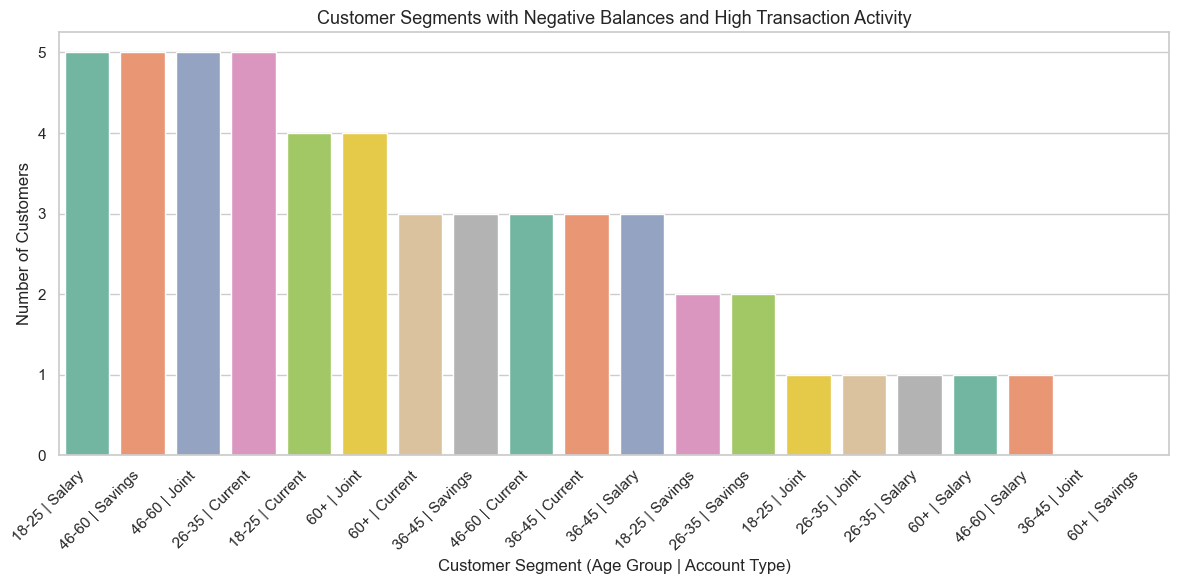

In [32]:
# --------------------------------------------------------------------
# Answer 8 – Customer segments with
#              negative balances and high transaction activity
# Segments used:
#   - Age group
#   - Account type
# --------------------------------------------------------------------

# 1. Create customer-level behaviour features
#    We calculate per customer:
#       - total transactions
#       - average account balance
# --------------------------------------------------------------------
customer_profile = (
    df
        .groupby("customer_id")
        .agg(
            txn_count=("transaction_id", "count"),
            avg_balance=("account_balance", "mean"),
            age=("age", "median"),
            account_type=("account_type", "first")
        )
        .reset_index()
)


# --------------------------------------------------------------------
# 2. Define age segments (business friendly buckets)
# --------------------------------------------------------------------
customer_profile["age_group"] = pd.cut(
    customer_profile["age"],
    bins=[17, 25, 35, 45, 60, 100],
    labels=["18-25", "26-35", "36-45", "46-60", "60+"]
)


# --------------------------------------------------------------------
# 3. Define high transaction activity threshold
#    (customers above 75th percentile of transaction count)
# --------------------------------------------------------------------
high_activity_threshold = customer_profile["txn_count"].quantile(0.75)


# --------------------------------------------------------------------
# 4. Filter customers with:
#       - negative average balance
#       - high transaction activity
# --------------------------------------------------------------------
risky_active_customers = customer_profile[
    (customer_profile["avg_balance"] < 0) &
    (customer_profile["txn_count"] >= high_activity_threshold)
].copy()


print("High-activity threshold (transactions):", high_activity_threshold)
print("Number of risky & highly active customers:",
      risky_active_customers.shape[0])


# --------------------------------------------------------------------
# 5. Build customer segment view
#    (age group + account type)
# --------------------------------------------------------------------
segment_summary = (
    risky_active_customers
        .groupby(["age_group", "account_type"])
        .agg(
            customer_count=("customer_id", "count"),
            avg_txn_count=("txn_count", "mean"),
            avg_negative_balance=("avg_balance", "mean")
        )
        .reset_index()
        .sort_values("customer_count", ascending=False)
)

print(segment_summary)


# --------------------------------------------------------------------
# 6. Visualization – Customer segments most exposed to risk
#    (colored professional chart)
# --------------------------------------------------------------------

sns.set_theme(style="whitegrid")

plt.figure(figsize=(12, 6))

segment_summary["segment"] = (
    segment_summary["age_group"].astype(str)
    + " | "
    + segment_summary["account_type"]
)

palette = sns.color_palette("Set2", n_colors=len(segment_summary))

sns.barplot(
    data=segment_summary,
    x="segment",
    y="customer_count",
    palette=palette
)

plt.title(
    "Customer Segments with Negative Balances and High Transaction Activity",
    fontsize=13
)

plt.xlabel("Customer Segment (Age Group | Account Type)")
plt.ylabel("Number of Customers")

plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()

In [33]:
# 9️⃣ Do certain transaction types (UPI, ATM, Card, IMPS, NEFT) create more failures or disputes?

  transaction_type  total_txns  failed_txns  total_amount  failure_rate
0              ATM       13236         4431  9.804282e+08     33.476881
1             Card       13263         4558  9.855721e+08     34.366282
2             IMPS       13300         4450  9.811054e+08     33.458647
3             NEFT       13281         4410  9.929159e+08     33.205331
4              UPI       13458         4465  1.000988e+09     33.177292


C:\Users\sc978\AppData\Local\Temp\ipykernel_12564\2103217070.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


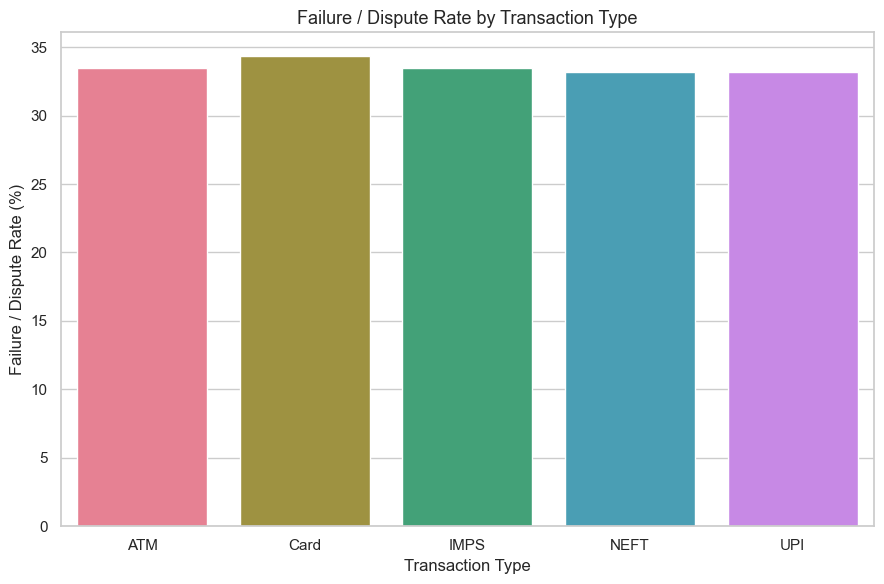

C:\Users\sc978\AppData\Local\Temp\ipykernel_12564\2103217070.py:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


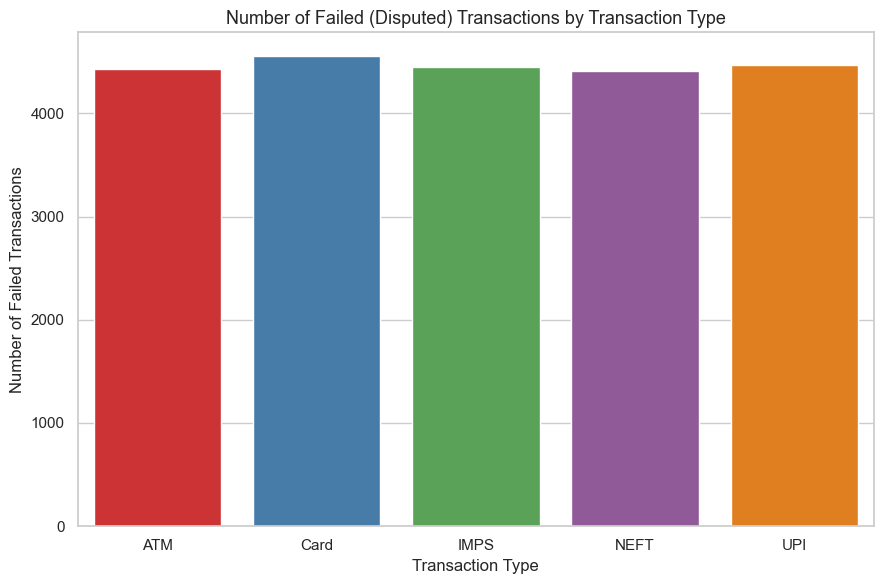

In [34]:
# --------------------------------------------------------------------
# Answer 9 – Transaction type level failure / dispute analysis
# --------------------------------------------------------------------

# 1. Keep only relevant transaction types for this study
#    (as mentioned in the business question)
# --------------------------------------------------------------------
focus_types = ["UPI", "ATM", "Card", "IMPS", "NEFT"]

df = df[df["transaction_type"].isin(focus_types)].copy()


# --------------------------------------------------------------------
# 2. Create failure flag
#    We treat Failed transactions as disputes / issues
# --------------------------------------------------------------------
df["is_failed"] = (df["transaction_status"] == "Failed").astype(int)


# --------------------------------------------------------------------
# 3. Transaction type level aggregation
#    We calculate:
#       - total transactions
#       - total failed transactions
#       - total transaction value
# --------------------------------------------------------------------
txn_type_summary = (
    df
        .groupby("transaction_type")
        .agg(
            total_txns=("transaction_id", "count"),
            failed_txns=("is_failed", "sum"),
            total_amount=("transaction_amount", "sum")
        )
        .reset_index()
)


# --------------------------------------------------------------------
# 4. Failure (dispute) rate calculation
# --------------------------------------------------------------------
txn_type_summary["failure_rate"] = (
    txn_type_summary["failed_txns"] /
    txn_type_summary["total_txns"]
) * 100

print(txn_type_summary)


# --------------------------------------------------------------------
# 5. Visualization – Failure / dispute rate by transaction type
#    (colored professional bar chart)
# --------------------------------------------------------------------

sns.set_theme(style="whitegrid")

plt.figure(figsize=(9, 6))

palette1 = sns.color_palette("husl", n_colors=len(txn_type_summary))

sns.barplot(
    data=txn_type_summary,
    x="transaction_type",
    y="failure_rate",
    palette=palette1
)

plt.title(
    "Failure / Dispute Rate by Transaction Type",
    fontsize=13
)

plt.xlabel("Transaction Type")
plt.ylabel("Failure / Dispute Rate (%)")

plt.tight_layout()
plt.show()


# --------------------------------------------------------------------
# 6. Visualization – Failed transaction volume (count)
#    This shows operational load by channel
# --------------------------------------------------------------------

plt.figure(figsize=(9, 6))

palette2 = sns.color_palette("Set1", n_colors=len(txn_type_summary))

sns.barplot(
    data=txn_type_summary,
    x="transaction_type",
    y="failed_txns",
    palette=palette2
)

plt.title(
    "Number of Failed (Disputed) Transactions by Transaction Type",
    fontsize=13
)

plt.xlabel("Transaction Type")
plt.ylabel("Number of Failed Transactions")

plt.tight_layout()
plt.show()

In [35]:
# 🔟 Which customers show abnormal transaction behaviour patterns?

Total abnormal customers identified: 5168


C:\Users\sc978\AppData\Local\Temp\ipykernel_12564\4176582085.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


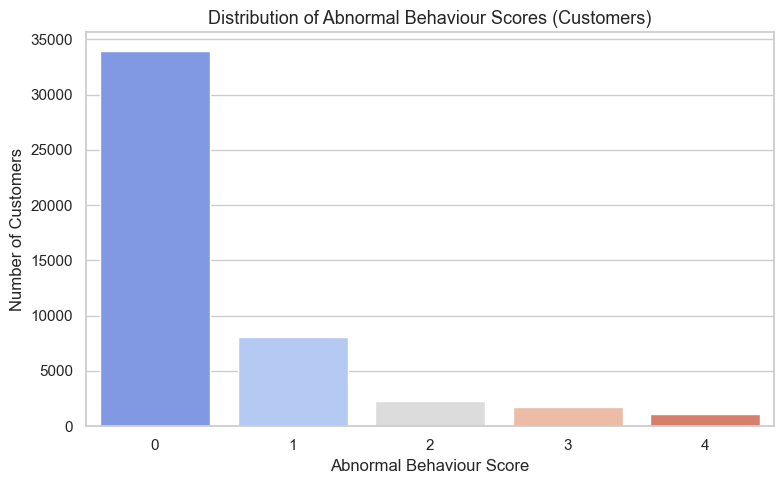

In [36]:
# --------------------------------------------------------------------
# Answer 10 – Abnormal customer behaviour detection
# --------------------------------------------------------------------

# 1. Create behaviour features per customer
#    We capture:
#     - transaction volume
#     - total amount moved
#     - average amount
#     - number of cities used
#     - number of devices used
#     - number of high-risk transactions
#     - number of failed transactions
# --------------------------------------------------------------------

df["is_high_risk"] = (df["fraud_risk_score"] >= 0.7).astype(int)
df["is_failed"] = (df["transaction_status"] == "Failed").astype(int)

customer_behavior = (
    df
        .groupby("customer_id")
        .agg(
            txn_count=("transaction_id", "count"),
            total_amount=("transaction_amount", "sum"),
            avg_amount=("transaction_amount", "mean"),
            unique_cities=("city", "nunique"),
            unique_devices=("device", "nunique"),
            high_risk_txns=("is_high_risk", "sum"),
            failed_txns=("is_failed", "sum")
        )
        .reset_index()
)


# --------------------------------------------------------------------
# 2. Create abnormality flags using robust thresholds
#    (95th percentile – common fraud analytics practice)
# --------------------------------------------------------------------

txn_threshold = customer_behavior["txn_count"].quantile(0.95)
city_threshold = customer_behavior["unique_cities"].quantile(0.95)
device_threshold = customer_behavior["unique_devices"].quantile(0.95)
risk_threshold = customer_behavior["high_risk_txns"].quantile(0.95)

customer_behavior["flag_high_txn"] = customer_behavior["txn_count"] >= txn_threshold
customer_behavior["flag_many_cities"] = customer_behavior["unique_cities"] >= city_threshold
customer_behavior["flag_many_devices"] = customer_behavior["unique_devices"] >= device_threshold
customer_behavior["flag_high_risk_txns"] = customer_behavior["high_risk_txns"] >= risk_threshold


# --------------------------------------------------------------------
# 3. Abnormal behaviour score
#    (how many abnormal patterns each customer triggers)
# --------------------------------------------------------------------

flag_cols = [
    "flag_high_txn",
    "flag_many_cities",
    "flag_many_devices",
    "flag_high_risk_txns"
]

customer_behavior["abnormal_score"] = customer_behavior[flag_cols].sum(axis=1)


# --------------------------------------------------------------------
# 4. Abnormal customers
#    (customers triggering at least 2 abnormal signals)
# --------------------------------------------------------------------

abnormal_customers = customer_behavior[
    customer_behavior["abnormal_score"] >= 2
].sort_values(
    by="abnormal_score",
    ascending=False
)

print("Total abnormal customers identified:",
      abnormal_customers.shape[0])

abnormal_customers.head(20)


# --------------------------------------------------------------------
# 5. Visualization – distribution of abnormal scores
#    (colored professional chart)
# --------------------------------------------------------------------

sns.set_theme(style="whitegrid")

plt.figure(figsize=(8, 5))

palette = sns.color_palette("coolwarm", n_colors=customer_behavior["abnormal_score"].nunique())

sns.countplot(
    data=customer_behavior,
    x="abnormal_score",
    palette=palette
)

plt.title(
    "Distribution of Abnormal Behaviour Scores (Customers)",
    fontsize=13
)

plt.xlabel("Abnormal Behaviour Score")
plt.ylabel("Number of Customers")

plt.tight_layout()
plt.show()